In [31]:
# matplotlib used plotting. Not required to run the code.
import matplotlib.pyplot as plt
import numpy as np

import MCEq
from MCEq.core import MCEqRun
from MCEq.core import config, MCEqRun
import crflux.models as crf

In [44]:
# Initalize MCEq by creating the user interface object MCEqRun
mceq = MCEqRun(
    # High-energy hadronic interaction model
    interaction_model='SIBYLL23C',
    # cosmic ray flux at the top of the atmosphere
    primary_model = (crf.HillasGaisser2012, 'H3a'),
    # zenith angle
    theta_deg = 0.
)

# Solve the equation system
mceq.solve()

# Obtain the result
# Multiply fluxes be E**mag to resolve the features of the steep spectrum
mag = 0
neutron_flux = mceq.get_solution('total_n0', mag) + mceq.get_solution('total_nbar0', mag)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [205]:
#Dictionary for results
flux = {}

#Define equidistant grid in cos(theta)
# angles = np.arccos(np.linspace(1,0,41))*180./np.pi
angles = np.linspace(0,1,21)*90

for i, theta in enumerate(angles):
    print(theta)
    mceq.set_theta_deg(theta)
    mceq.solve()
    #_conv means conventional (mostly pions and kaons)
    flux[theta] =  mceq.get_solution('total_n0', mag) + mceq.get_solution('total_nbar0', mag)

0.0
4.5
9.0
13.500000000000002
18.0
22.5
27.000000000000004
31.500000000000004
36.0
40.5
45.0
49.50000000000001
54.00000000000001
58.5
63.00000000000001
67.5
72.0
76.50000000000001
81.0
85.5
90.0


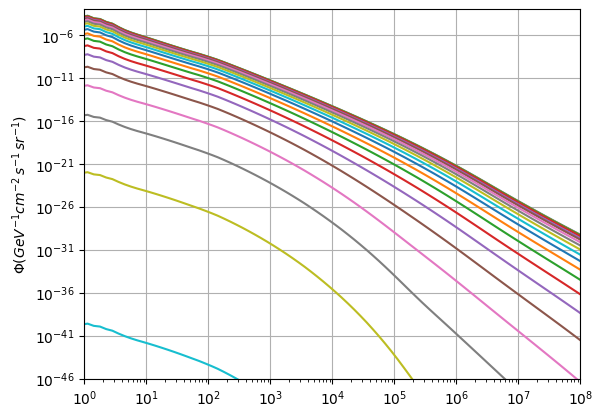

In [206]:
frac = []
for theta in angles:
    x = mceq.e_grid
    y = flux[theta] * np.pi *2
    # if np.cos(theta)>0.5:
    #     continue
    # print(theta, np.cos(theta/180*np.pi))
    # plt.loglog(x, y / (np.cos(theta/180*np.pi)**2), label=f'{theta}')
    plt.loglog(x, y, label=f'{theta}')
    frac.append(flux[theta][11]/flux[0][11])

plt.ylabel(r'$\Phi (GeV^{-1} cm^{-2} \, s^{-1} \, sr^{-1}$)')

plt.xlim(1,1e8)
plt.ylim(1e-46,1e-3)
plt.grid()

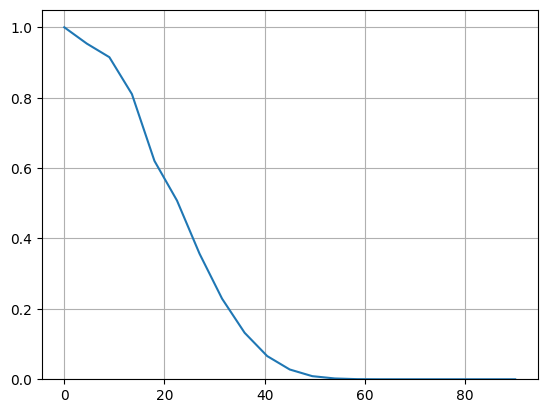

In [207]:
plt.plot(angles, frac)
plt.ylim(0,)
plt.grid()

In [218]:
def cumsum0(y):
    y=np.array(y)
    return np.cumsum(y) - 0.5*y[0] - 0.5*y

def sample_neutron_energy_zenith(flux_dict, energies, num_samples=1, energy_range=None):
    """
    Samples neutron energy and zenith angle from given differential flux distributions.
    
    Parameters:
        flux_dict (dict):
            - Keys are zenith angles (in degrees).
            - Values are numpy arrays of differential flux corresponding to the energy points.
        energies (numpy array):
            - A numpy array of energy values corresponding to the flux arrays.
        num_samples (int):
            - The number of neutron samples to generate.
        energy_range (tuple, optional):
            - A tuple (E_min, E_max) to specify the energy range to sample from.
    
    Returns:
        numpy array of shape (num_samples, 2):
            - Each row contains (sampled_energy, sampled_zenith_angle)
    """
    # Convert angles to a sorted list
    zenith_angles = np.array(sorted(flux_dict.keys()))
    zenith_radians = zenith_angles * np.pi / 180  # Convert to radians

    # Apply energy range filter if specified
    if energy_range is not None:
        E_min, E_max = energy_range
        energy_mask = (energies >= E_min) & (energies <= E_max)
        filtered_energies = energies[energy_mask]
        filtered_flux_dict = {angle: flux[energy_mask] for angle, flux in flux_dict.items()}
    else:
        filtered_energies = energies
        filtered_flux_dict = flux_dict
    
    # Compute total flux at each zenith angle (integrating over filtered energy)
    total_flux_per_angle = np.array([np.trapz(filtered_flux_dict[angle], filtered_energies) for angle in zenith_angles])
    
    # Compute the solid angle element for each zenith angle
    d_omega = 2 * np.pi * np.sin(zenith_radians) * np.diff(np.concatenate(([0], zenith_radians)))
    
    # Normalize flux by solid angle to get correct probability distribution
    weighted_flux = total_flux_per_angle * d_omega
    weighted_cdf = cumsum0(weighted_flux)
    weighted_cdf /= weighted_cdf[-1]  # Normalize to [0,1]
    
    # Sample continuous zenith angles using inverse transform sampling
    sampled_zenith_angles = np.interp(np.random.rand(num_samples), weighted_cdf, zenith_radians)
    
    sampled_energies = []

    # print(zenith_radians)
    # plt.plot(zenith_radians, weighted_cdf)
    for angle in sampled_zenith_angles:
        # Interpolate flux for continuous angles
        nearest_indices = np.searchsorted(zenith_radians, angle, side='left')
        if nearest_indices == 0:
            interpolated_flux = filtered_flux_dict[zenith_angles[0]]
        elif nearest_indices == len(zenith_angles):
            interpolated_flux = filtered_flux_dict[zenith_angles[-1]]
        else:
            lower_angle, upper_angle = zenith_angles[nearest_indices - 1], zenith_angles[nearest_indices]
            lower_flux, upper_flux = filtered_flux_dict[lower_angle], filtered_flux_dict[upper_angle]
            interpolated_flux = lower_flux + (upper_flux - lower_flux) * (angle - lower_angle * np.pi / 180) / ((upper_angle - lower_angle) * np.pi / 180)
        
        # Normalize the flux to create a probability distribution for energy sampling
        cumulative_distribution = cumsum0(interpolated_flux)
        cumulative_distribution /= cumulative_distribution[-1]  # Normalize to [0,1]
        
        # Sample energy using inverse transform sampling
        random_value = np.random.rand()
        sampled_energy = np.interp(random_value, cumulative_distribution, filtered_energies)
        sampled_energies.append(sampled_energy)
    
    # Return samples as a NumPy array
    return np.column_stack((sampled_energies, sampled_zenith_angles * 180/np.pi))

In [235]:
energies = mceq.e_grid
flux_dict = flux
samples = sample_neutron_energy_zenith(flux_dict, energies, num_samples=1000000, energy_range=[1e5,1e12])

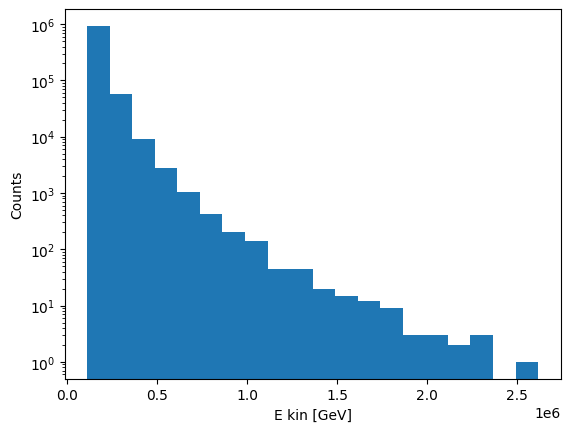

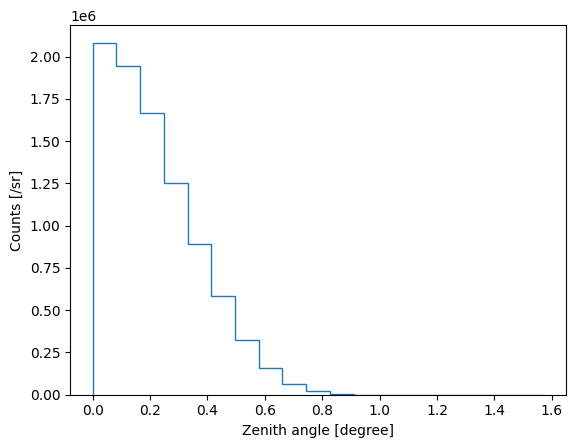

In [236]:
plt.hist(samples[:,0],bins=20);
plt.yscale("log")
plt.xlabel("E kin [GeV]")
plt.ylabel("Counts")
plt.show()


bins=np.linspace(0,np.pi/2,20)
bin_width = np.diff(bins)
bin_centers = bins[:-1] + 0.5*bin_width
bin_sr = [2*np.pi*np.sin(0.5*(bins[i]+bins[i+1])) * bin_width[i] for i in range(len(bin_width))]

n,ibins = np.histogram(samples[:,1] * np.pi/180,bins=bins);
plt.stairs(n/bin_sr, ibins)
plt.xlabel("Zenith angle [degree]")
plt.ylabel("Counts [/sr]")
plt.show()
